# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction

The Zeeman slower is a device used to slow down a beam of atoms using the radiation pressure from a counter-propagating monochromatic laser beam, while compensating for the changing Doppler shift.
Therefore, the laser exerts a force on the atoms, slowing them down over a certain distance with a force, $F_{scatt} = \sigma_{abs} I/c = \hbar k R_{scatt}$, where $\sigma_{abs}$ is the absorption cross-section, $I$ is the laser intensity, $c$ is the speed of light, $\hbar$ is the reduced Planck constant, $k$ is the wavevector of the laser light, and $R_{scatt}$ is the scattering rate $$R_{scatt} = \frac{\Gamma}{2} \frac{\Omega^2/2}{\delta^2+\Omega^2/2+\Gamma^2/4}$$ where $\Gamma$ is the linewidth, $\Omega$ is the Rabi frequency, and $\delta (z) = \omega - \omega_0 +kv(z)$ is the detuning where $\omega$ is the laser frequency, $\omega_0$ is the atomic transition frequency, and $kv(z)$ is the Doppler shift.
We can also define the laser detuning at rest as $\delta_0 = \omega - \omega_0$ such that the detuning becomes $\delta (z) = \delta_0 +kv(z)$.

Defining the saturation parameter as $s = I/I_{sat} = 2 \Omega^2/\Gamma^2$, where $I_{sat}$ is the saturation intensity, we can rewrite the scattering force as:$$F_{scatt} = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+4(\delta/\Gamma)^2}.$$

When the intensity tends to infinity ($s \gg 1$) and the detuning is zero ($\delta = 0$), the scattering rate reaches its maximum value of $R_{scatt,max} = \Gamma/2$, leading to a maximum deceleration of the atoms given by:
$$a_{max} = \frac{F_{scatt,max}}{m} = \frac{\hbar k}{m} \frac{\Gamma}{2} = \frac{v_r}{2\tau}$$
where $m$ is the mass of the atom, $v_r = \hbar k / m$ is the recoil velocity, and $\tau$ is the excited state lifetime.

### Species properties and constants
Here we define relevant properties (mass, wavelength and linewidth) of several common atomic species used for laser cooling.
Such that we can use their linewidth to study in first instance the range where the scattering rate is significant for different saturation parameters.
We also define some useful constants and import necessary libraries.

In [2]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck's constant)
hbar = hh / (2.0 * math.pi)
mu = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)

# Species dropdown with mass, wavelength (m), gamma (rad/s), and saturation intensity (mW/cm^2)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2 * math.pi * 34.6e6, 'sat_intensity': 60.0},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2 * math.pi * 32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2 * math.pi * 6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2 * math.pi * 5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2 * math.pi * 9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2 * math.pi * 29.0e6},
}

# Dropdown = an interactive ipywidgets selection control that lets the user pick
# exactly one option from a list. Its current selection is available as `species.value`
# and is used in later cells to look up `species_data[species.value]` and refresh plots.
# Changing this widget will trigger observers (attached later in the notebook) to
# recompute figures and labels for the chosen atom.
species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
)

# If the interactive widgets already exist, refresh them so display labels
# pick up any newly edited parameter values (e.g., gamma).
for refresh_func_name in ("refresh_simple", "refresh_advanced"):
    refresh_callable = globals().get(refresh_func_name)
    if callable(refresh_callable):
        try:
            refresh_callable()
        except Exception as exc:
            print(f"Warning: {refresh_func_name} failed to refresh ({exc})")

### Scattering rate

Here we define a function that calculates the scattering rate as a function of detuning and saturation parameter to study its dependence around zero detuning within the range of Ca linewidth.
It shows that for a given detuning, increasing the saturation parameter increases the scattering rate until a limit of $\Gamma / 2$; the larger the detuning, the more $s$ it takes to reach the limit of the scattering rate.
For a given saturation parameter, the scattering rate peaks at zero detuning and it is symmetric for positive and negative detuning; the larger saturation parameter, the broader and peak closer to $\Gamma / 2$.

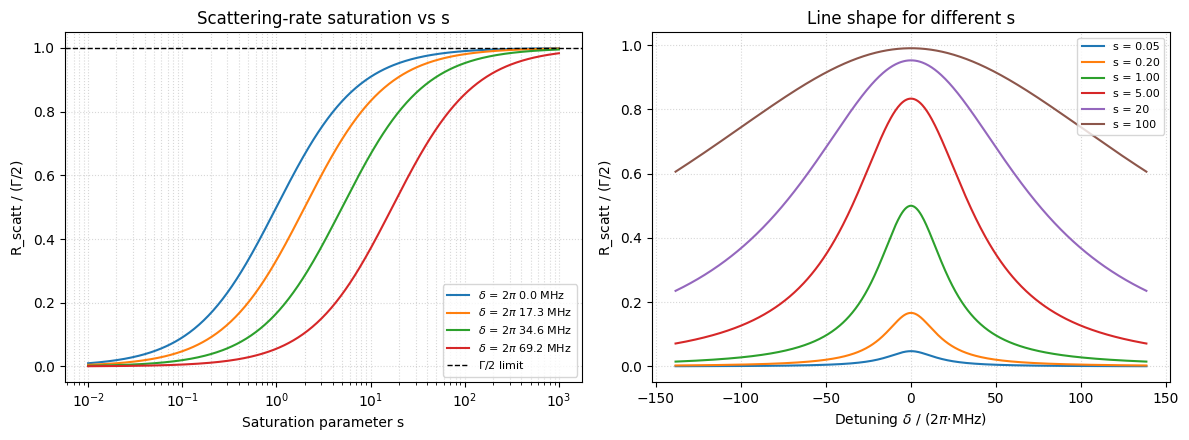

In [3]:
# Visualize how the scattering rate depends on saturation parameter and detuning
def scattering_rate(s, delta, gamma):
    return 0.5 * gamma * (s / (1.0 + s + 4.0 * (delta / gamma) ** 2))

current_species = species_data[species.value]
gamma_val = current_species["gamma"]

s_values = np.logspace(-2, 3, 400)
detuning_values = np.linspace(-4 * gamma_val, 4 * gamma_val, 600)

detuning_samples = [0.0, 0.5 * gamma_val, 1.0 * gamma_val, 2.0 * gamma_val]
saturation_samples = [0.05, 0.2, 1.0, 5.0, 20.0, 100.0]

rates_vs_s = {delta: scattering_rate(s_values, delta, gamma_val) for delta in detuning_samples}
rates_vs_delta = {s: scattering_rate(s, detuning_values, gamma_val) for s in saturation_samples}

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))

for delta, rates in rates_vs_s.items():
    label = f"$\delta$ = 2$\pi$ {delta / (2 * math.pi * 1e6):.1f} MHz"
    ax_left.plot(s_values, rates / (gamma_val / 2), label=label)
ax_left.axhline(1.0, color="k", ls="--", lw=1, label="$\Gamma$/2 limit")
ax_left.set_xscale("log")
ax_left.set_xlabel("Saturation parameter s")
ax_left.set_ylabel("R_scatt / ($\Gamma$/2)")
ax_left.set_title("Scattering-rate saturation vs s")
ax_left.legend(loc="lower right", fontsize=8)
ax_left.grid(True, which="both", ls=":", alpha=0.5)

for s_val, rates in rates_vs_delta.items():
    label = f"s = {s_val:.2f}" if s_val < 10 else f"s = {s_val:.0f}"
    ax_right.plot(detuning_values / (2 * math.pi * 1e6), rates / (gamma_val / 2), label=label)
ax_right.set_xlabel("Detuning $\delta$ / (2$\pi$·MHz)")
ax_right.set_ylabel("R_scatt / ($\Gamma$/2)")
ax_right.set_title("Line shape for different s")
ax_right.legend(loc="upper right", fontsize=8)
ax_right.grid(True, ls=":", alpha=0.5)

plt.tight_layout()
plt.show()

### Velocity and magnetic field profiles

Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0 = v(z=0)$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which is usually expressed $a=\eta a_{max}$ where $\eta \in [0,1]$ is typically between 0.5 and 0.8 to give some margin compared to the maximum deceleration.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f = v(z=L)$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$$
such that we can express the velocity profile:
$$v(z) = \sqrt{v_0^2 - \left(v_0^2 - v_f^2\right)\frac{z}{L}}$$

Assuming $v_f=0$, $L = \frac{v_0^2}{2 \eta a_{max}}$ and $v(z) = v_0 \sqrt{1 - \frac{z}{L}}$.

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_L (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu$ is the Bohr magneton, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process until $v_f = 0$ via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is for a general final velocity $v_f$,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{v_0^2 - v_f^2}{v_0^2}\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= - \hbar \delta_0$.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## The following code aims to study the decreasing-field Zeeman slower for a general final velocity vf

In [4]:
# Clean up previous UI instances to prevent stacked displays when this cell is re-run
for _widget_name in ("_advanced_ui", "_advanced_output"):
    # Widgets stick around across executions; closing avoids duplicated plots/controls.
    _existing_widget = globals().get(_widget_name)
    if _existing_widget is not None:
        try:
            _existing_widget.close()
        except Exception:
            pass

def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """Plot magnetic field (Gauss) and velocity using discrete markers."""
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color="tab:blue")
    ax1.scatter(z_plt, B_plt * 1e4, color="tab:blue", s=15, label="B(z) [G]")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, ls="--", alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color="tab:orange")
    ax2.scatter(z_plt, v_plt, color="tab:orange", s=15, label="v(z) [m/s]")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    max_B = np.nanmax(B_plt * 1e4) if np.size(B_plt) else 1.0
    max_v = np.nanmax(v_plt) if np.size(v_plt) else 1.0
    max_B = max(1e-8, max_B) * 1.05
    max_v = max(1e-8, max_v) * 1.05
    ax1.set_ylim(0.0, max_B)
    ax2.set_ylim(0.0, max_v)
    ax1.set_title(f"Zeeman slower profile (L = {L_plt*100:.2f} cm)")
    plt.tight_layout()
    plt.show()

def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, B_bias=250, eta=0.5, n_points=500):
    # Convert inputs to SI units and compute basic limits.
    m = mass_amu * amu
    k = 2 * math.pi / wavelength
    F_max = hbar * k * gamma / 2.0
    a_max = F_max / m
    a = eta * a_max
    if a <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    # Ideal-length and magnetic profile for the increasing-field design.
    L = (v0 * v0 - vf * vf) / (2.0 * a)
    B_delta = hbar * k / (mu * g_eff) * v0
    B_bias_T = B_bias * 1e-4  # Gauss slider uses CGS units.
    z = np.linspace(0.0, L, n_points)
    v = np.sqrt(v0**2 - (v0**2 - vf**2) * z / L)
    BB = B_bias_T + B_delta * (1 - np.sqrt(1 - ((v0**2 - vf**2) / v0**2) * (z / L)))
    detu = - mu * g_eff * (B_bias_T + B_delta) / hbar
    diagnostics = {
        "F_max": F_max,
        "a_max": a_max,
        "a": a,
        "B_delta": B_delta,
        "detuning": detu,
    }
    return z, v, BB, L, detu, diagnostics

# Slider definitions (all use continuous_update=False to avoid overwhelming plots).
v0_adv = w.FloatSlider(description="v0 (m/s)", value=1000.0, min=400.0, max=1200.0, step=5.0, continuous_update=False)
vf_adv = w.FloatSlider(description="vf (m/s)", value=50.0, min=0.0, max=100.0, step=5.0, continuous_update=False)
eta_adv = w.FloatSlider(description="eta", value=0.75, min=0.01, max=1.0, step=0.01, continuous_update=False)
B_bias_adv = w.FloatSlider(description="B_bias (G)", value=250.0, min=1.0, max=500.0, step=1.0, continuous_update=False)
g_eff_adv = w.FloatSlider(description="g_eff", value=1.0, min=0, max=2.0, step=0.01, continuous_update=False)
points_adv = w.IntSlider(description="points", value=600, min=50, max=1000, step=50, continuous_update=False)

# Dynamic labels and output container.
wavelength_label_advanced = w.HTML()
gamma_label_advanced = w.HTML()
summary_label_advanced = w.HTML()
out_advanced = w.Output()

def update_info_advanced():
    d = species_data[species.value]
    wavelength_label_advanced.value = f"<b>&lambda;</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_advanced.value = f"<b>&Gamma;/2&pi;</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"

def refresh_advanced(change=None):
    d = species_data[species.value]
    update_info_advanced()
    try:
        z, v, B, L, detu, diag = compute_B_z_forces(
            mass_amu=d['mass'],
            wavelength=d['wavelength'],
            gamma=d['gamma'],
            v0=v0_adv.value,
            vf=vf_adv.value,
            eta=eta_adv.value,
            B_bias=B_bias_adv.value,
            g_eff=g_eff_adv.value,
            n_points=points_adv.value,
        )
    except Exception as exc:
        summary_label_advanced.value = f"<span style='color:red'>Parameter error: {exc}</span>"
        with out_advanced:
            clear_output(wait=True)
            print("Parameter error:", exc)
        return
    with out_advanced:
        clear_output(wait=True)
        plot_profile(z, v, B, L)
    summary_label_advanced.value = (
        f"<b>Slower length</b>: {L*100:.2f} cm"
        f"<br><b>Max force</b>: {diag['F_max']:.3e} N"
        f"<br><b>Design detuning</b>: {diag['detuning']/1e9:.2f} GHz"
        f"<br><b>B0</b>: {diag['B_delta']*1e4:.1f} G"
    )
    # Persist the latest profile + metadata so later cells (phase-space) can reuse it.
    globals()["_advanced_state"] = {
        "species": species.value,
        "species_props": dict(d),
        "z": z,
        "v": v,
        "B": B,
        "L": L,
        "detuning": detu,
        "diagnostics": diag,
        "params": {
            "v0": v0_adv.value,
            "vf": vf_adv.value,
            "eta": eta_adv.value,
            "B_bias": B_bias_adv.value,
            "g_eff": g_eff_adv.value,
            "points": points_adv.value,
        },
    }

_advanced_observers = globals().get("_advanced_observers", [])
for widget, handler in _advanced_observers:
    try:
        widget.unobserve(handler, names='value')
    except Exception:
        pass
_advanced_observers = []

advanced_widgets = (species, v0_adv, vf_adv, eta_adv, B_bias_adv, g_eff_adv, points_adv)
for widget in advanced_widgets:
    widget.observe(refresh_advanced, names='value')
    _advanced_observers.append((widget, refresh_advanced))

ui_advanced = w.VBox([
    w.HBox([species, wavelength_label_advanced, gamma_label_advanced]),
    w.HBox([v0_adv, vf_adv, eta_adv]),
    w.HBox([B_bias_adv, g_eff_adv, points_adv]),
    summary_label_advanced,
])

globals()["_advanced_ui"] = ui_advanced
globals()["_advanced_output"] = out_advanced

refresh_advanced()
display(ui_advanced, out_advanced)

Output()

## Scattering force map and phase-space trajectories

The motion of the atoms in the Zeeman slower can be described by the 1D Newtonian model
$$m \frac{d^2z}{dt^2} = F_{scatt}(z,v) = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+\frac{4 \delta(z,v)^2}{\Gamma^2}}$$
where the scattering force $F_{scatt}(z,v)$ depends on both position and velocity through the detuning $\delta(z,v) = \delta_0 + k v + \mu B(z)/\hbar$ for the increasing field configuration (branch).

In [5]:
# Phase-space trajectories for the ideal Zeeman field profile (uses the advanced widget profile)
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run cell 9 (advanced Zeeman slower widget) before executing this cell so the magnetic profile is available.")

species_name = advanced_state.get("species", species.value)
species_props = advanced_state.get("species_props", species_data.get(species_name, {}))
fallback_props = species_data.get(species_name, species_data[species.value])
spec = {**fallback_props, **species_props}

# Pull the stored species values so this cell mirrors the widget configuration.
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec.get("sat_intensity", 60.0)
k = 2 * math.pi / wavelength

params = advanced_state.get("params", {})
g_eff_val = float(params.get("g_eff", g_eff_adv.value if "g_eff_adv" in globals() else 1.0))
v_capture = float(params.get("v0", 500.0))
v_final = float(params.get("vf", 50.0))

if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf. Rerun cell 9 with valid parameters.")

z_axis = np.asarray(advanced_state["z"])
B_profile_T = np.asarray(advanced_state["B"])
L_design = float(advanced_state.get("L", 0.0))

if z_axis.size == 0 or B_profile_T.size == 0:
    raise RuntimeError("Advanced magnetic profile is empty. Re-run cell 9 with valid parameters.")

diag = advanced_state.get("diagnostics", {})
F_max = float(diag.get("F_max", hbar * k * gamma / 2.0))
a_max = float(diag.get("a_max", F_max / mass))
ideal_detuning = float(advanced_state.get("detuning", -mu * g_eff_val * (B_profile_T[0]) / hbar))

# Extend the spatial grid beyond the slower exit assuming zero field.
extension_length = max(0.05, 0.25 * L_design)
extension_points = max(50, int(len(z_axis) * extension_length / max(z_axis[-1] - z_axis[0], 1e-6)))
z_extra = np.linspace(z_axis[-1], z_axis[-1] + extension_length, extension_points + 1)[1:]
B_zero_tail = np.zeros_like(z_extra)

z_profile = np.concatenate([z_axis, z_extra])
B_profile_extended = np.concatenate([B_profile_T, B_zero_tail])

# Slider controls to explore different scattering intensities and laser detunings around the ideal design.
intensity_slider = w.FloatSlider(
    description="I (mW/cm²)",
    value=600.0,
    min=10.0,
    max=2000.0,
    step=10.0,
    continuous_update=False,
)

span_ghz = max(0.5, abs(ideal_detuning / 1e9) * 0.5)
detuning_slider = w.FloatSlider(
    description="Detu (GHz)",
    value=ideal_detuning / 1e9,
    min=ideal_detuning / 1e9 - span_ghz,
    max=ideal_detuning / 1e9 + span_ghz,
    step=0.1,
    continuous_update=False,
)

ideal_detuning_label = w.HTML(
    f"<b>Ideal detuning</b>: {ideal_detuning / 1e9:.3f} GHz (from cell 9 profile)"
)
sat_info_label = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in if sat_in else 0.0:.2f}"
)

# Sample velocities well below zero so the force map shows deceleration all the way through the stop.
v_min = -max(0.25 * v_capture, 100.0)
v_max = v_capture * 1.05
vel_axis = np.linspace(v_min, v_max, 500)
gray_cmap = ListedColormap(plt.cm.Greys(np.linspace(0.0, 0.85, 256)))

z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = (z_axis[-1] - z_axis[0]) / max(v_capture, 1.0)
flight_time = max(flight_time, 1e-6)
base_dt = flight_time / max(len(z_axis) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-6

# Interactive plot to reflect slider selections without rerunning the entire cell stack.
def plot_phase_space(intensity_mw_cm2, detuning_ghz):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0
    delta_laser = detuning_ghz * 1e9
    sat_info_label.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
    )

    def scattering_force_vector(B_T, velocities):
        delta = delta_laser + k * velocities + g_eff_val * mu * B_T / hbar
        denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
        return hbar * k * gamma / 2.0 * (s0_val / denom)

    def integrate_trajectory(v_init):
        # Give much higher iteration budgets to slow trajectories so they can traverse the slower and free-flight tail.
        speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
        max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
        traj_z = [z_min]
        traj_v = [v_init]
        for _ in range(max_steps):
            v_curr = traj_v[-1]
            z_curr = traj_z[-1]
            if abs(v_curr) < min_speed:
                prev = traj_v[-2] if len(traj_v) > 1 else 1.0
                v_curr = np.copysign(min_speed, prev)
                traj_v[-1] = v_curr
            z_sample = float(np.clip(z_curr, z_min, z_max))
            B_val = np.interp(z_sample, z_profile, B_profile_extended)
            force = scattering_force_vector(B_val, v_curr)
            accel = -force / mass  # Laser pushes opposite to +z beam direction.
            v_next = v_curr + accel * base_dt
            z_next = z_curr + v_curr * base_dt
            traj_v.append(v_next)
            traj_z.append(z_next)
            if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
                break
        return np.asarray(traj_z), np.asarray(traj_v)

    force_grid = np.zeros((len(z_profile), len(vel_axis)))
    for i, B_val in enumerate(B_profile_extended):
        force_grid[i] = scattering_force_vector(B_val, vel_axis)

    initial_velocities = np.linspace(v_final * 0.9, v_capture, 10)

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(
        force_grid.T,
        extent=[z_profile[0], z_profile[-1], vel_axis[0], vel_axis[-1]],
        origin="lower",
        aspect="auto",
        cmap=gray_cmap,
    )
    ax.axvline(z_axis[-1], color="red", linestyle="--", linewidth=1, label="Slower end")
    for v_init in initial_velocities:
        traj_z, traj_v = integrate_trajectory(v_init)
        if traj_z.size < 2:
            continue
        ax.plot(traj_z, traj_v, label=f"v0={v_init:.0f} m/s")

    ax.set_xlabel("z (m)")
    ax.set_ylabel("v (m/s)")
    ax.set_title(f"Phase space with stored profile ({species_name}, L={L_design*100:.2f} cm)")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Scattering force (N)")
    ax.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

controls = w.VBox([
    w.HBox([intensity_slider, detuning_slider]),
    ideal_detuning_label,
    sat_info_label,
])
phase_output = w.interactive_output(
    plot_phase_space,
    {"intensity_mw_cm2": intensity_slider, "detuning_ghz": detuning_slider},
)

display(controls, phase_output)

Output()

In [6]:
# Final velocity diagnostics after the Zeeman slower
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run cell 9 (advanced Zeeman slower widget) before executing this cell so the magnetic profile is available.")

species_name = advanced_state.get("species", species.value)
species_props = advanced_state.get("species_props", species_data.get(species_name, {}))
fallback_props = species_data.get(species_name, species_data[species.value])
spec = {**fallback_props, **species_props}

wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec.get("sat_intensity", 60.0)
k = 2 * math.pi / wavelength

params = advanced_state.get("params", {})
g_eff_val = float(params.get("g_eff", g_eff_adv.value if "g_eff_adv" in globals() else 1.0))
v_capture = float(params.get("v0", 500.0))
v_final = float(params.get("vf", 50.0))

z_axis = np.asarray(advanced_state["z"])
B_profile_T = np.asarray(advanced_state["B"])
L_design = float(advanced_state.get("L", 0.0))

if z_axis.size == 0 or B_profile_T.size == 0:
    raise RuntimeError("Advanced magnetic profile is empty. Re-run cell 9 with valid parameters.")

ideal_detuning = float(advanced_state.get("detuning", -mu * g_eff_val * (B_profile_T[0]) / hbar))

extension_length = max(0.05, 0.25 * L_design)
extension_points = max(100, int(len(z_axis) * extension_length / max(z_axis[-1] - z_axis[0], 1e-6)))
z_extra = np.linspace(z_axis[-1], z_axis[-1] + extension_length, extension_points + 1)[1:]
B_zero_tail = np.zeros_like(z_extra)

z_profile = np.concatenate([z_axis, z_extra])
B_profile_extended = np.concatenate([B_profile_T, B_zero_tail])

z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = (z_axis[-1] - z_axis[0]) / max(v_capture, 1.0)
flight_time = max(flight_time, 1e-6)
base_dt = flight_time / max(len(z_axis) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-6

intensity_slider_final = w.FloatSlider(
    description="I (mW/cm²)",
    value=600.0,
    min=10.0,
    max=2000.0,
    step=10.0,
    continuous_update=False,
 )

span_ghz = max(0.5, abs(ideal_detuning / 1e9) * 0.5)
detuning_slider_final = w.FloatSlider(
    description="Detu (GHz)",
    value=ideal_detuning / 1e9,
    min=ideal_detuning / 1e9 - span_ghz,
    max=ideal_detuning / 1e9 + span_ghz,
    step=0.1,
    continuous_update=False,
 )

ideal_detuning_label_final = w.HTML(
    f"<b>Ideal detuning</b>: {ideal_detuning / 1e9:.3f} GHz (from cell 9 profile)"
 )
sat_info_label_final = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in if sat_in else 0.0:.3f}"
 )
summary_label_final = w.HTML()

initial_velocities = np.linspace(v_final * 0.9, v_capture, 15)


def simulate_final_velocities(intensity_mw_cm2, detuning_ghz):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0
    delta_laser = detuning_ghz * 1e9
    sat_info_label_final.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
    )

    def scattering_force_vector(B_T, velocities):
        delta = delta_laser + k * velocities + g_eff_val * mu * B_T / hbar
        denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
        return hbar * k * gamma / 2.0 * (s0_val / denom)

    def integrate_to_exit(v_init):
        speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
        max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
        v_curr = v_init
        z_curr = z_min
        final_z = z_curr
        final_v = v_curr
        for _ in range(max_steps):
            if abs(v_curr) < min_speed:
                v_curr = np.copysign(min_speed, final_v if abs(final_v) > 1e-9 else 1.0)
            z_sample = float(np.clip(z_curr, z_min, z_max))
            B_val = np.interp(z_sample, z_profile, B_profile_extended)
            force = scattering_force_vector(B_val, v_curr)
            accel = -force / mass
            v_next = v_curr + accel * base_dt
            z_next = z_curr + v_curr * base_dt
            final_v = v_next
            final_z = z_next
            v_curr, z_curr = v_next, z_next
            if z_next >= z_max:
                break
        return final_v, final_z

    results = [integrate_to_exit(v0_val)[0] for v0_val in initial_velocities]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(initial_velocities, results, marker="o", lw=1.5, label="Simulated final velocity")
    ax.axhline(0.0, color="gray", ls="--", lw=1, label="0 m/s")
    ax.set_xlabel("Initial velocity (m/s)")
    ax.set_ylabel("Final velocity (m/s)")
    ax.set_title("Final velocities after Zeeman slower + drift")
    ax.grid(True, ls=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

    summary_label_final.value = (
        f"<b>Intensity</b>: {intensity_mw_cm2:.0f} mW/cm²"
        f"<br><b>Detuning</b>: {detuning_ghz:.2f} GHz"
        f"<br><b>Min final v</b>: {min(results):.2f} m/s"
        f"<br><b>Max final v</b>: {max(results):.2f} m/s"
    )


controls_final = w.VBox([
    w.HBox([intensity_slider_final, detuning_slider_final]),
    ideal_detuning_label_final,
    sat_info_label_final,
    summary_label_final,
 ])
final_velocity_output = w.interactive_output(
    simulate_final_velocities,
    {"intensity_mw_cm2": intensity_slider_final, "detuning_ghz": detuning_slider_final},
 )

display(controls_final, final_velocity_output)

Output()

In [ ]:
# Estimate atoms slowed to a target window using a Maxwell-Boltzmann beam model
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run cell 9 (advanced Zeeman slower widget) before executing this cell so the magnetic profile is available.")
if "intensity_slider_final" not in globals() or "detuning_slider_final" not in globals():
    raise RuntimeError("Run the final-velocity diagnostics cell once so the shared sliders exist before using this estimator.")

species_name = advanced_state.get("species", species.value)
species_props = advanced_state.get("species_props", species_data.get(species_name, {}))
fallback_props = species_data.get(species_name, species_data[species.value])
spec = {**fallback_props, **species_props}

wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec.get("sat_intensity", 60.0)
k = 2 * math.pi / wavelength
k_B = 1.380649e-23

params = advanced_state.get("params", {})
g_eff_val = float(params.get("g_eff", g_eff_adv.value if "g_eff_adv" in globals() else 1.0))
v_capture = float(params.get("v0", 500.0))
v_final = float(params.get("vf", 50.0))

z_axis = np.asarray(advanced_state["z"])
B_profile_T = np.asarray(advanced_state["B"])
L_design = float(advanced_state.get("L", 0.0))
if z_axis.size == 0 or B_profile_T.size == 0:
    raise RuntimeError("Advanced magnetic profile is empty. Re-run cell 9 with valid parameters.")

extension_length = max(0.05, 0.25 * L_design)
extension_points = max(100, int(len(z_axis) * extension_length / max(z_axis[-1] - z_axis[0], 1e-6)))
z_extra = np.linspace(z_axis[-1], z_axis[-1] + extension_length, extension_points + 1)[1:]
B_zero_tail = np.zeros_like(z_extra)
z_profile = np.concatenate([z_axis, z_extra])
B_profile_extended = np.concatenate([B_profile_T, B_zero_tail])

z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = (z_axis[-1] - z_axis[0]) / max(v_capture, 1.0)
flight_time = max(flight_time, 1e-6)
base_dt = flight_time / max(len(z_axis) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-6

initial_velocity_grid = np.linspace(max(1.0, v_final * 0.2), v_capture, 250)
window_slider_max = max(150.0, v_capture * 1.2)

temperature_slider_mb = w.FloatSlider(
    description="Beam T (K)",
    value=700.0,
    min=100.0,
    max=1500.0,
    step=10.0,
    continuous_update=False,
 )
flux_slider_mb = w.FloatLogSlider(
    description="Atom flux (1/s)",
    value=1e9,
    base=10,
    min=4,
    max=12,
    step=0.1,
    continuous_update=False,
 )
window_slider_mb = w.FloatRangeSlider(
    description="Final v window (m/s)",
    value=(30.0, 60.0),
    min=0.0,
    max=window_slider_max,
    step=1.0,
    continuous_update=False,
 )
mb_summary_label = w.HTML()

def maxwell_speed_pdf(speed, particle_mass, temperature):
    beta = particle_mass / (2.0 * k_B * max(temperature, 1e-6))
    prefactor = 4.0 * math.pi * (beta / math.pi) ** 1.5
    return prefactor * (speed ** 2) * np.exp(-beta * speed ** 2)

def estimate_atoms(temperature_K, atom_flux_per_s, velocity_window):
    intensity_val = float(intensity_slider_final.value)
    detuning_val = float(detuning_slider_final.value)
    window_low, window_high = velocity_window
    if window_high <= window_low:
        mb_summary_label.value = "<span style='color:red'>Velocity window must have max > min.</span>"
        return

    s0_val = intensity_val / sat_in if sat_in else 0.0
    delta_laser = detuning_val * 1e9

    def scattering_force_vector(B_T, velocities):
        delta = delta_laser + k * velocities + g_eff_val * mu * B_T / hbar
        denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
        return hbar * k * gamma / 2.0 * (s0_val / denom)

    def integrate_to_exit(v_init):
        speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
        max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
        v_curr = v_init
        z_curr = z_min
        final_v = v_curr
        for _ in range(max_steps):
            if abs(v_curr) < min_speed:
                v_curr = np.copysign(min_speed, final_v if abs(final_v) > 1e-9 else 1.0)
            z_sample = float(np.clip(z_curr, z_min, z_max))
            B_val = np.interp(z_sample, z_profile, B_profile_extended)
            force = scattering_force_vector(B_val, v_curr)
            accel = -force / mass
            v_next = v_curr + accel * base_dt
            z_next = z_curr + v_curr * base_dt
            final_v = v_next
            v_curr, z_curr = v_next, z_next
            if z_next >= z_max:
                break
        return final_v

    final_velocities = np.array([integrate_to_exit(v0) for v0 in initial_velocity_grid])
    pdf_vals = maxwell_speed_pdf(initial_velocity_grid, mass, temperature_K)
    dv = np.gradient(initial_velocity_grid)
    prob_weights = pdf_vals * dv
    captured_prob = prob_weights.sum()

    window_mask = (final_velocities >= window_low) & (final_velocities <= window_high)
    prob_window = prob_weights[window_mask].sum()
    atoms_in_window = atom_flux_per_s * prob_window
    captured_flux = atom_flux_per_s * captured_prob
    efficiency = (prob_window / captured_prob * 100.0) if captured_prob > 0 else 0.0

    upper_plot = max(window_high * 1.5, float(np.nanmax(final_velocities)) * 1.05, 100.0)
    bins = np.linspace(0.0, upper_plot, 40)
    hist, edges = np.histogram(final_velocities, bins=bins, weights=prob_weights)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.bar(centers, hist, width=np.diff(edges), color="tab:blue", alpha=0.7, label="Final v probability mass")
    ax.axvspan(window_low, window_high, color="tab:orange", alpha=0.2, label="Target window")
    ax.set_xlabel("Final velocity (m/s)")
    ax.set_ylabel("Probability mass")
    ax.set_title("Maxwell-Boltzmann weighted final velocity distribution")
    ax.grid(True, ls=":", alpha=0.4)
    ax.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

    mb_summary_label.value = (
        f"<b>Beam temperature</b>: {temperature_K:.0f} K"
        f"<br><b>Total atom flux</b>: {atom_flux_per_s:.2e} s⁻¹"
        f"<br><b>Captured flux (v ≤ {v_capture:.0f} m/s)</b>: {captured_flux:.2e} s⁻¹"
        f"<br><b>Atoms slowed to {window_low:.0f}-{window_high:.0f} m/s</b>: {atoms_in_window:.2e} s⁻¹"
        f"<br><b>Fraction of captured atoms in window</b>: {efficiency:.2f}%"
        f"<br><b>Current intensity</b>: {intensity_val:.0f} mW/cm² | <b>Detuning</b>: {detuning_val:.2f} GHz"
    )

controls_mb = w.VBox([temperature_slider_mb, flux_slider_mb, window_slider_mb, mb_summary_label])
mb_output = w.interactive_output(
    estimate_atoms,
    {
        "temperature_K": temperature_slider_mb,
        "atom_flux_per_s": flux_slider_mb,
        "velocity_window": window_slider_mb,
    },
 )

display(controls_mb, mb_output)